# Spark: processamento de linguagem natural

## 01. Introdução
---

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("analise_nlp") \
    .getOrCreate()

25/09/04 15:31:34 WARN Utils: Your hostname, DSN-1003 resolves to a loopback address: 127.0.1.1; using 172.29.1.248 instead (on interface enp3s0)
25/09/04 15:31:34 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/04 15:31:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


[Download csv file](https://cdn3.gnarususercontent.com.br/2275-spark-processamento-linguagem-natural/01/imdb-reviews-pt-br.csv)

or

[kaggle IMDB PT-BR](https://www.kaggle.com/datasets/luisfredgs/imdb-ptbr)

In [2]:
dados = spark.read.csv(
    "content/imdb-reviews-pt-br.csv",
    escape="\"",
    header=True,
    inferSchema=True
)

### Para saber mais: PLN ou NLP

Esse curso irá usar algumas técnicas do Processamento de Linguagem Natural, na qual é a tecnologia usada para **ajudar os computadores a compreender a linguagem natural** do ser humano e isso tem sido desenvolvido cada vez mais ao longo dos anos, com o avanço computacional e os estudos na área.

Podemos usar a sigla **PLN** para “**Processamento de Linguagem Natural**” ou também a sigla **NLP** que vem do termo em inglês “**Natural Language Processing**“. Essa área do conhecimento tem como principal objetivo **ler**, **decifrar**, **entender e dar sentido às línguas humanas**. Nesse sentido, a maioria das técnicas de NLP também utiliza o aprendizado de máquina (famoso machine learning) para obter significado das línguas humanas.

Pensando em termos de aplicações em nosso cotidiano, podemos citar o funcionamento da Alexa ou qualquer **interação entre humanos e máquinas de forma falada**. Seu funcionamento pode ser resumido com os seguintes passos:

1. A pessoa fala com a máquina;
2. A máquina capta o áudio;
3. O áudio é convertido para texto;
4. O texto passa pelo pré-processamento;
5. Os dados são convertidos para áudio; e
6. Finalmente, a máquina responde o humano, reproduzindo o passo anterior.

Vale lembrar que os dados textuais cada vez mais têm gerado um **grande volume** de informações, tornando o processamento e análise desses dados ainda mais complexos. Por isso é necessário recursos apropriados para esse cenário e aqui podemos contar com a performance do **Spark** e suas funcionalidades.

Espero que você tenha compreendido mais sobre o NLP e o volume de dados que é gerado nesse campo, vou deixar aqui o [artigo do Thiago](https://www.alura.com.br/artigos/o-que-e-pln) sobre PNL e também o [artigo do Igor](https://www.alura.com.br/artigos/iniciando-projeto-spark-no-colab) que fala um pouco mais do Spark e a criação de um projeto no Colab.

### Explorando os dados

In [3]:
dados.count()

49459

In [4]:
dados.printSchema()

root
 |-- id: integer (nullable = true)
 |-- text_en: string (nullable = true)
 |-- text_pt: string (nullable = true)
 |-- sentiment: string (nullable = true)



In [5]:
dados.show(10)

+---+--------------------+--------------------+---------+
| id|             text_en|             text_pt|sentiment|
+---+--------------------+--------------------+---------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|
|  2|This is an exampl...|Este é um exemplo...|      neg|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|
|  6|A funny thing hap...|Uma coisa engraça...|      neg|
|  7|This German horro...|Este filme de ter...|      neg|
|  8|Being a long-time...|Sendo um fã de lo...|      neg|
|  9|"Tokyo Eyes" tell...|"Tokyo Eyes" fala...|      neg|
| 10|Wealthy horse ran...|Fazendeiros ricos...|      neg|
+---+--------------------+--------------------+---------+
only showing top 10 rows



In [6]:
dados.groupBy("sentiment").count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      neg|24765|
|      pos|24694|
+---------+-----+



In [7]:
dados.select("text_pt").where("id = 190").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text_pt                                                                                                                          

In [8]:
dados.select("text_pt").where("id = 12427").show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text_pt                                                                                                                                                                                                                                                                        

## 02. Limpeza e processamento
---

### Processo e bibliotecas

#### Limpando e processando os dados

Para que o computador compreenda nosse linguagem é importante realizar algumas transformações no intuito de facilitar essa compreensão. Para isso, primeiramente podemos realizar a **limpeza dos dados**, que consiste na **remoção de caracteres que não contribui** na distinção dos sentimentos dos comentários dos nossos clientes, podemos citar por exemplo, remover caracteres especiais e espaços no início e fim dos comentários.

Logo após a limpeza de caracteres não relevantes, precisamos realizar o procedimento de **Tokenização**, que consiste no processo de **dividir uma frase** em palavras ou tokens (parte do texto) individuais.

E para finalizar o processamento dos nossos dados, iremos realizar a retirada de **stopwords**, ou seja, aquelas palavras que não auxiliam na classificação ou identificação do texto, em sua maioria são **preposições**, **artigos**, **pronomes**...

In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [10]:
SEED = 101
amostra = dados.select("text_pt").sample(0.1, seed=SEED)
tudo = [texto["text_pt"] for texto in amostra.collect()]

In [11]:
wordcloud = WordCloud(
    background_color="white",
    width=1000,
    height=600,
    collocations=False,
    prefer_horizontal=1
).generate(str(tudo))

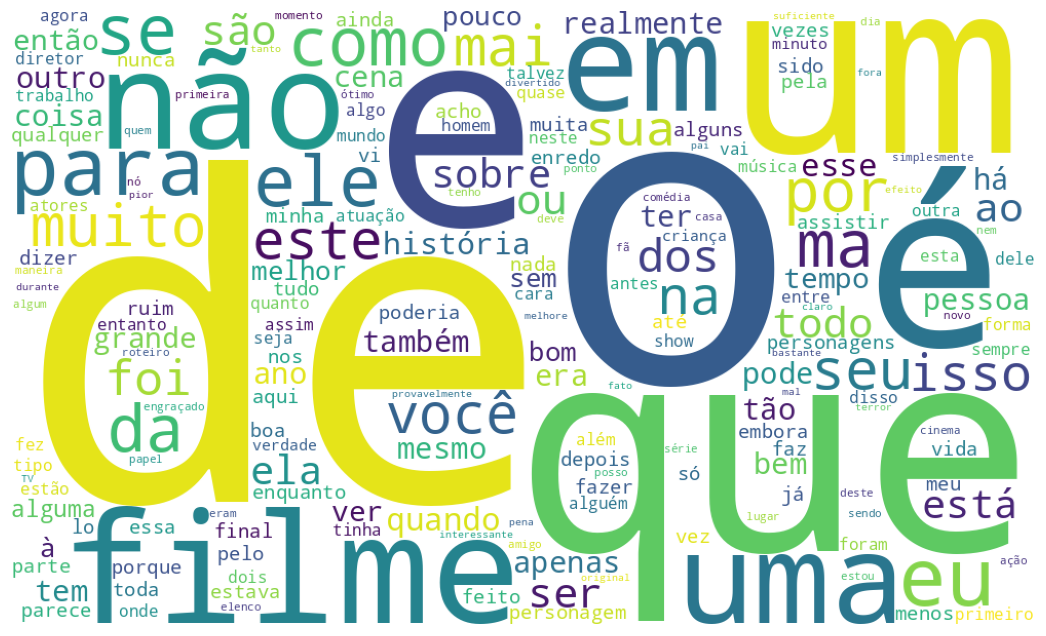

In [12]:
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Caractere especial

In [13]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [14]:
exemplo = spark.createDataFrame([
    ("Oi, JP! Blz?",),
    ("$$$\\ |~ Parabéns ~| \\$$$",),
    ("(#amovc #paz&amor ^.^)",),
    ("=>->'...``` vc foi selecionad@  ```...'<-<=",),
    ("{comprar: arroz; feijão e pepino} //",),
    ("!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~",),
    ("ana@gmail.com",),
], ["textos"])

<>:7: SyntaxWarning: invalid escape sequence '\]'
<>:7: SyntaxWarning: invalid escape sequence '\]'
/tmp/ipykernel_411269/4408176.py:7: SyntaxWarning: invalid escape sequence '\]'
  ("!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~",),


In [15]:
import pyspark.sql.functions as f

exemplo = exemplo.withColumn("texto_regex", f.regexp_replace("textos", "[$#,\"!%&'()*+-./:;<=>?@^_`{|}~\\\\]", ""))
exemplo.show(truncate=False)

+-------------------------------------------+------------------------------+
|textos                                     |texto_regex                   |
+-------------------------------------------+------------------------------+
|Oi, JP! Blz?                               |Oi JP Blz                     |
|$$$\ |~ Parabéns ~| \$$$                   |  Parabéns                    |
|(#amovc #paz&amor ^.^)                     |amovc pazamor                 |
|=>->'...``` vc foi selecionad@  ```...'<-<=| vc foi selecionad            |
|{comprar: arroz; feijão e pepino} //       |comprar arroz feijão e pepino |
|!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~           |[]                            |
|ana@gmail.com                              |anagmailcom                   |
+-------------------------------------------+------------------------------+



In [16]:
exemplo = exemplo.withColumn("texto_limpo", f.trim("texto_regex"))
exemplo.show(truncate=False)

+-------------------------------------------+------------------------------+-----------------------------+
|textos                                     |texto_regex                   |texto_limpo                  |
+-------------------------------------------+------------------------------+-----------------------------+
|Oi, JP! Blz?                               |Oi JP Blz                     |Oi JP Blz                    |
|$$$\ |~ Parabéns ~| \$$$                   |  Parabéns                    |Parabéns                     |
|(#amovc #paz&amor ^.^)                     |amovc pazamor                 |amovc pazamor                |
|=>->'...``` vc foi selecionad@  ```...'<-<=| vc foi selecionad            |vc foi selecionad            |
|{comprar: arroz; feijão e pepino} //       |comprar arroz feijão e pepino |comprar arroz feijão e pepino|
|!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~           |[]                            |[]                           |
|ana@gmail.com                       

In [17]:
dados = dados.withColumn("texto_regex", f.regexp_replace("text_pt", "[$#,\"!%&'()*+-./:;<=>?@^_`{|}~\\\\]", ""))
dados = dados.withColumn("texto_limpo", f.trim("texto_regex"))

In [18]:
dados.show(1, truncate=False)

+---+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------

### Tokenização

In [19]:
from pyspark.ml.feature import Tokenizer
from pyspark.sql.types import IntegerType

In [20]:
tokenizer = Tokenizer(inputCol="texto_limpo", outputCol="tokens")
tokenizado = tokenizer.transform(dados)

In [21]:
tokenizado.select("texto_limpo", "tokens").show()

+--------------------+--------------------+
|         texto_limpo|              tokens|
+--------------------+--------------------+
|Mais uma vez o Sr...|[mais, uma, vez, ...|
|Este é um exemplo...|[este, é, um, exe...|
|Primeiro de tudo ...|[primeiro, de, tu...|
|Nem mesmo os Beat...|[nem, mesmo, os, ...|
|Filmes de fotos d...|[filmes, de, foto...|
|Uma coisa engraça...|[uma, coisa, engr...|
|Este filme de ter...|[este, filme, de,...|
|Sendo um fã de lo...|[sendo, um, fã, d...|
|Tokyo Eyes fala d...|[tokyo, eyes, fal...|
|Fazendeiros ricos...|[fazendeiros, ric...|
|Cage interpreta u...|[cage, interpreta...|
|Primeiro de tudo ...|[primeiro, de, tu...|
|Então me diga  qu...|[então, me, diga,...|
|Uma grande decepç...|[uma, grande, dec...|
|Este filme é abso...|[este, filme, é, ...|
|Heres um decidida...|[heres, um, decid...|
|Na parte inferior...|[na, parte, infer...|
|A terra foi destr...|[a, terra, foi, d...|
|Muitas pessoas es...|[muitas, pessoas,...|
|A família de Nova...|[a, famíli

In [22]:
count_tokens = f.udf(lambda tokens: len(tokens), IntegerType())
tokenizado.select("texto_limpo", "tokens") \
    .withColumn("freq_tokens", count_tokens(f.col("tokens"))).show()

+--------------------+--------------------+-----------+
|         texto_limpo|              tokens|freq_tokens|
+--------------------+--------------------+-----------+
|Mais uma vez o Sr...|[mais, uma, vez, ...|        168|
|Este é um exemplo...|[este, é, um, exe...|        245|
|Primeiro de tudo ...|[primeiro, de, tu...|        213|
|Nem mesmo os Beat...|[nem, mesmo, os, ...|        324|
|Filmes de fotos d...|[filmes, de, foto...|        244|
|Uma coisa engraça...|[uma, coisa, engr...|        116|
|Este filme de ter...|[este, filme, de,...|        161|
|Sendo um fã de lo...|[sendo, um, fã, d...|        146|
|Tokyo Eyes fala d...|[tokyo, eyes, fal...|        130|
|Fazendeiros ricos...|[fazendeiros, ric...|        167|
|Cage interpreta u...|[cage, interpreta...|        106|
|Primeiro de tudo ...|[primeiro, de, tu...|        315|
|Então me diga  qu...|[então, me, diga,...|        247|
|Uma grande decepç...|[uma, grande, dec...|        107|
|Este filme é abso...|[este, filme, é, ...|     

### Para saber mais: RegexTokenizer()

Nos passos anteriores, nós aprendemos a aplicar a função `regex_replace()` para remover caracteres específicos da nossa base usando **expressões regulares** e depois conhecemos e aplicamos um processo importante no processamento de linguagem natural: a **tokenização**, usando o `tokenizer()` do MLlib,

E se eu te contar que aqui no PySpark podemos unir ambos os processos em uma só função? O nome da função é `RegexTokenizer()` também do MLlib, ou seja, está integrado ao PySpark e permite uma tokenização mais avançada com base na correspondência de expressão regular (regex).

Importante dizer que ambos os processos estão corretos, há quem queira otimizar o processo usando a aplicação do regex de forma automática através do `RegexTokenizer()`, e há outros problemas que vão precisar ter um maior controle sobre as especifidades das expressões regulares, para isso é indicado os processos - regex e tokenizer - de forma separada.

Legal, né? Que tal utilizar essa função e comparar as diferenças? Deixo aqui essa sugestão, ou seja, aplicar o `RegexTokenizer()` no projeto. Além disso, vou deixar também a [documentação do `RegexTokenizer()`](https://spark.apache.org/docs/3.5.4/ml-features.html#tokenizer) para você consultar e explorar um pouco mais sobre os seus argumentos e os métodos disponíveis. Ah! Ainda sobre regex, também vou te rexomendar o [artigo da Maria Gabriela](https://www.alura.com.br/artigos/principais-casos-uso-regex-para-tratamento-dados) sobre expressões regulares, que via de regra são utilizados no processo de manipulação de textos em geral para diferentes linguagens de programação.

### StopWords

In [23]:
data = [
    (1, "Spark é ótimo e NLP com Spark é fácil"),
    (0, "Spark MLlib não ajuda muito"),
    (1, "O MLlib do Spark ajuda e é fácil"),
]
col_names = ["label", "texto_limpo"]
df = spark.createDataFrame(data, col_names)

In [24]:
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
stop_A = stopwords.words("portuguese")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/cristoffer_pogan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
from pyspark.ml.feature import StopWordsRemover
stop_B = StopWordsRemover.loadDefaultStopWords("portuguese")

In [26]:
tokenizer = Tokenizer(inputCol="texto_limpo", outputCol="tokens")
tokenized = tokenizer.transform(df)

In [27]:
remover = StopWordsRemover(inputCol="tokens", outputCol="texto_final", stopWords=stop_A)
df = remover.transform(tokenized)

In [28]:
df.show(truncate=False)

+-----+-------------------------------------+-----------------------------------------------+---------------------------------+
|label|texto_limpo                          |tokens                                         |texto_final                      |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------+
|1    |Spark é ótimo e NLP com Spark é fácil|[spark, é, ótimo, e, nlp, com, spark, é, fácil]|[spark, ótimo, nlp, spark, fácil]|
|0    |Spark MLlib não ajuda muito          |[spark, mllib, não, ajuda, muito]              |[spark, mllib, ajuda]            |
|1    |O MLlib do Spark ajuda e é fácil     |[o, mllib, do, spark, ajuda, e, é, fácil]      |[mllib, spark, ajuda, fácil]     |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------+



In [29]:
remover = StopWordsRemover(inputCol="tokens", outputCol="texto_final", stopWords=stop_B)
df = remover.transform(tokenized)

In [30]:
df.show(truncate=False)

+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+
|label|texto_limpo                          |tokens                                         |texto_final                            |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+
|1    |Spark é ótimo e NLP com Spark é fácil|[spark, é, ótimo, e, nlp, com, spark, é, fácil]|[spark, é, ótimo, nlp, spark, é, fácil]|
|0    |Spark MLlib não ajuda muito          |[spark, mllib, não, ajuda, muito]              |[spark, mllib, ajuda]                  |
|1    |O MLlib do Spark ajuda e é fácil     |[o, mllib, do, spark, ajuda, e, é, fácil]      |[mllib, spark, ajuda, é, fácil]        |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+



In [31]:
remover = StopWordsRemover(inputCol="tokens", outputCol="texto_final")
feature_data = remover.transform(tokenizado)

In [32]:
feature_data.limit(11).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|              tokens|         texto_final|
+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Mais uma vez o Sr...|Mais uma vez o Sr...|[mais, uma, vez, ...|[mais, uma, vez, ...|
|  2|This is an exampl...|Este é um exemplo...|      neg|Este é um exemplo...|Este é um exemplo...|[este, é, um, exe...|[este, é, um, exe...|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|Primeiro de tudo ...|Primeiro de tudo ...|[primeiro, de, tu...|[primeiro, de, tu...|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|Nem mesmo os Beat...|Nem mesmo os Beat...|[nem, mesmo, os, ...|[nem, mesmo, os, ...|
|  5|B

In [33]:
feature_data.select("tokens", "texto_final") \
    .withColumn("freq_tokens", count_tokens(f.col("tokens"))) \
    .withColumn("freq_tokens_limpos", count_tokens(f.col("texto_final"))).show()

+--------------------+--------------------+-----------+------------------+
|              tokens|         texto_final|freq_tokens|freq_tokens_limpos|
+--------------------+--------------------+-----------+------------------+
|[mais, uma, vez, ...|[mais, uma, vez, ...|        168|               157|
|[este, é, um, exe...|[este, é, um, exe...|        245|               234|
|[primeiro, de, tu...|[primeiro, de, tu...|        213|               207|
|[nem, mesmo, os, ...|[nem, mesmo, os, ...|        324|               308|
|[filmes, de, foto...|[filmes, de, foto...|        244|               236|
|[uma, coisa, engr...|[uma, coisa, engr...|        116|               112|
|[este, filme, de,...|[este, filme, de,...|        161|               160|
|[sendo, um, fã, d...|[sendo, um, fã, d...|        146|               135|
|[tokyo, eyes, fal...|[tokyo, eyes, fal...|        130|               128|
|[fazendeiros, ric...|[fazendeiros, ric...|        167|               160|
|[cage, interpreta...|[ca

### Para saber mais: palavras vazias

As StopWords ou Palavras Vazias são palavras comuns em qualquer idioma que ocorrem com alta frequência, porém não participam ativamente para o significado de uma frase.

Normalmente as palavras vazias são preposições, pronomes, artigos e até alguns verbos que ocorrem em abundância em um texto, mas que fornecem pouca ou nenhuma informação exclusiva que poderia ser utilizada em um procedimento de classificação ou clusterização, isso fica mais evidente quando analisamos a lista de stopwords em português da biblioteca NLTK (Natural Language Toolkit) que pode ser conferida [neste arquivo](https://cdn3.gnarususercontent.com.br/2275-spark-processamento-linguagem-natural/02/portuguese_NLTK.zip).

Quando criamos nosso vocabulário de palavras baseado no conjunto de dados que estamos analisando, é comum fazer a remoção das stopwords, uma vez que o tamanho do vocabulário aumenta a complexidade computacional e os requisitos de memória que serão necessários para seguir com as outras etapas do processamento de linguagem natural.

Vale lembrar que há diversos problemas em NLP que necessitam de uma listagem personalizada de palavras vazias, ou ainda, em outros casos a lista de StopWords podem conter informações úteis, e descartá-las nem sempre é útil para sua análise. Exemplos disso podem ser observados em casos que precisamos distinguir entidades no texto como "O Teatro Mágico", "A Bela e a Fera", ou "Firefox OS", onde as letras "a", "e", e "o" não podem ser descartados como artigos, pois compõem um substantivo único. Além disso, contextos que envolvem análise de ironia ou metáfora precisam de uma lista de stopwords personalizada, pois as stopwords em uma lista padrão podem ajudar a dar o sentido nessas frases.

## 03. Vetorização das palavras
---

### Bag of words

In [34]:
from pyspark.ml.feature import CountVectorizer
cv = CountVectorizer(inputCol="texto_final", outputCol="count_vec")
model = cv.fit(df)
df = model.transform(df)

In [35]:
df.select("texto_final", "count_vec").show(truncate=False)

+---------------------------------------+-------------------------------------+
|texto_final                            |count_vec                            |
+---------------------------------------+-------------------------------------+
|[spark, é, ótimo, nlp, spark, é, fácil]|(7,[0,1,3,5,6],[2.0,2.0,1.0,1.0,1.0])|
|[spark, mllib, ajuda]                  |(7,[0,2,4],[1.0,1.0,1.0])            |
|[mllib, spark, ajuda, é, fácil]        |(7,[0,1,2,3,4],[1.0,1.0,1.0,1.0,1.0])|
+---------------------------------------+-------------------------------------+



In [36]:
model.vocabulary

['spark', 'é', 'mllib', 'fácil', 'ajuda', 'nlp', 'ótimo']

In [37]:
model = cv.fit(feature_data)
count_vectorizer_features = model.transform(feature_data)

In [38]:
count_vectorizer_features.select("texto_final", "count_vec").limit(5).show()

+--------------------+--------------------+
|         texto_final|           count_vec|
+--------------------+--------------------+
|[mais, uma, vez, ...|(160359,[0,1,2,3,...|
|[este, é, um, exe...|(160359,[0,1,2,3,...|
|[primeiro, de, tu...|(160359,[0,1,2,3,...|
|[nem, mesmo, os, ...|(160359,[0,1,2,3,...|
|[filmes, de, foto...|(160359,[0,1,2,3,...|
+--------------------+--------------------+



25/09/04 15:31:51 WARN DAGScheduler: Broadcasting large task binary with size 1873.5 KiB


In [39]:
# model.vocabulary

### Hashing TF

In [40]:
from pyspark.ml.feature import HashingTF
hashing_tf = HashingTF(inputCol="texto_final", outputCol="hashing_tf")
hashing_tf.setNumFeatures(50)
htf_featurized_data = hashing_tf.transform(count_vectorizer_features)

In [41]:
htf_featurized_data.select("texto_final", "hashing_tf").limit(5).show()

+--------------------+--------------------+
|         texto_final|          hashing_tf|
+--------------------+--------------------+
|[mais, uma, vez, ...|(50,[0,1,3,4,5,6,...|
|[este, é, um, exe...|(50,[0,1,2,3,4,5,...|
|[primeiro, de, tu...|(50,[0,1,2,3,4,5,...|
|[nem, mesmo, os, ...|(50,[0,1,3,4,5,6,...|
|[filmes, de, foto...|(50,[0,2,3,4,5,6,...|
+--------------------+--------------------+



### TF-IDF

In [42]:
from pyspark.ml.feature import IDF
idf = IDF(inputCol="hashing_tf", outputCol="features")
idf_model = idf.fit(htf_featurized_data)
tfidf_featurized_data = idf_model.transform(htf_featurized_data)

25/09/04 15:31:53 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors
                                                                                

In [43]:
tfidf_featurized_data.select("texto_final", "features").limit(5).show()

+--------------------+--------------------+
|         texto_final|            features|
+--------------------+--------------------+
|[mais, uma, vez, ...|(50,[0,1,3,4,5,6,...|
|[este, é, um, exe...|(50,[0,1,2,3,4,5,...|
|[primeiro, de, tu...|(50,[0,1,2,3,4,5,...|
|[nem, mesmo, os, ...|(50,[0,1,3,4,5,6,...|
|[filmes, de, foto...|(50,[0,2,3,4,5,6,...|
+--------------------+--------------------+



### Pipeline de transformação

In [44]:
tfidf_featurized_data.groupBy("sentiment").count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      neg|24765|
|      pos|24694|
+---------+-----+



In [45]:
from pyspark.ml.feature import StringIndexer
string_indexer = StringIndexer(inputCol="sentiment", outputCol="label")
dados = string_indexer.fit(dados).transform(dados)

In [46]:
dados.groupBy(["sentiment", "label"]).count().show()

+---------+-----+-----+
|sentiment|label|count|
+---------+-----+-----+
|      neg|  0.0|24765|
|      pos|  1.0|24694|
+---------+-----+-----+



In [47]:
from pyspark.ml import Pipeline
tokenizer = Tokenizer(inputCol="texto_limpo", outputCol="tokens")
stopwords = StopWordsRemover(inputCol="tokens", outputCol="texto_final")
hashing_tf = HashingTF(inputCol=stopwords.getOutputCol(), outputCol="htf", numFeatures=1_000)
tfidf = IDF(inputCol="htf", outputCol="features")
pipeline = Pipeline(stages=[tokenizer, stopwords, hashing_tf, tfidf])

In [48]:
dados_transformados = pipeline.fit(dados).transform(dados)

In [49]:
dados_transformados.limit(5).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|label|              tokens|         texto_final|                 htf|            features|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Mais uma vez o Sr...|Mais uma vez o Sr...|  0.0|[mais, uma, vez, ...|[mais, uma, vez, ...|(1000,[8,14,16,22...|(1000,[8,14,16,22...|
|  2|This is an exampl...|Este é um exemplo...|      neg|Este é um exemplo...|Este é um exemplo...|  0.0|[este, é, um, exe...|[este, é, um, exe...|(1000,[10,17,24,3...|(1000,[10,17,24,3...|
|  3|First of all I ha...|Primeiro de tudo ...|   

### Para saber mais: pipeline()

Executar todas as transformações de forma **faseada** ao longo do código traz **maior familiaridade** com os procedimentos que estão sendo realizados, porém se cada um dos passos já é compreensível pelas pessoas que estão escrevendo o código, então podemos otimizar todo o processo utilizando a função [`pipeline()`](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.Pipeline.html).

No pipeline é definido a **sequência de passos** em uma **ordem específica** alinhado ao que você deseja fazer na base de dados. No nosso caso, o objetivo do pipeline é unificar todas as transformações feitas nos dados até agora em uma sequência de passos para uma única execução.

No entanto, diminuir o tamanho do código não é o único benefício encontrado ao usar essa classe, imagine que reunir todas as classes usadas em uma única célula traz mais **legibilidade** e **facilita a leitura do código**. Além disso, como já foi declarada a ordem exata dos passos, mitigamos o erro de execuções em uma ordem incorreta.

Espero que você tenha compreendido que o uso da função `pipeline()` executa tarefas específicas que contribui para um objetivo maior, além de entregar um código mais replicável e profissional.

## 04. Treinando o modelo
---

### Árvore de Decisão

In [50]:
feature_df = dados_transformados.select("features", "label")

In [51]:
feature_df.limit(5).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [52]:
feature_df.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



In [56]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier

tokenizer = Tokenizer(inputCol="texto_limpo", outputCol="tokens")
stopwords = StopWordsRemover(inputCol="tokens", outputCol="texto_final")
hashing_tf = HashingTF(inputCol=stopwords.getOutputCol(), outputCol="htf", numFeatures=1_000)
tfidf = IDF(inputCol="htf", outputCol="features")
dt = DecisionTreeClassifier(featuresCol="features", labelCol="label", maxDepth=10)

pipeline = Pipeline(stages=[tokenizer, stopwords, hashing_tf, tfidf, dt])

### Amostra e Treino

In [57]:
treino, teste = dados.randomSplit([0.7, 0.3], seed=SEED)

In [58]:
dt_model = pipeline.fit(treino)

In [59]:
predictions = dt_model.transform(teste)

In [60]:
predictions.show()

+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+----------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|label|              tokens|         texto_final|                 htf|            features| rawPrediction|         probability|prediction|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+----------+
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|Filmes de fotos d...|Filmes de fotos d...|  0.0|[filmes, de, foto...|[filmes, de, foto...|(1000,[7,9,12,24,...|(1000,[7,9,12,24,...|    [8.0,40.0]|[0.16666666666666...|       1.0|
|  6|A funny thing hap...|Uma coisa engraça...|     

## 05.Explicando os resultados
---

### Teste e métricas

In [61]:
predictions.select("label", "prediction").show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



In [62]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
acuracia = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})

In [63]:
print(f"{acuracia=}")

acuracia=0.6499299859971994


### Para saber mais: avaliando

Há diversas métricas de avaliação de classificadores, além da acurácia que utilizamos na aula, podemos citar outras, tais como: o recall, precision e o f1-score. Outro recurso visual também bastante utilizado é a matriz de confusão. Todas essas métricas utilizam o conceito de falso-positivo, falso-negativo, verdadeiro-negativo e verdadeiro-positivo.

Para entender melhor cada uma dessas métricas, vou deixar aqui o [Alura+ do Bruno](https://cursos.alura.com.br/extra/alura-mais/metricas-de-avaliacao-para-classificacao-c1440) que exemplifica as principais métricas para avaliar modelos de machine learning de classificação.

### Nova frase

In [65]:
nova_base = spark.createDataFrame([
    (1, "This is without a doubt the worst movie I have ever seen, I hated the acting of the actors."),
    (0, "I loved the movie, excellent acting!"),
], ["id", "texto_limpo"])

In [66]:
nova_classe = dt_model.transform(nova_base)

In [67]:
nova_classe.show()

+---+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+----------+
| id|         texto_limpo|              tokens|         texto_final|                 htf|            features|rawPrediction|         probability|prediction|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+----------+
|  1|This is without a...|[this, is, withou...|[without, doubt, ...|(1000,[35,43,269,...|(1000,[35,43,269,...|[376.0,959.0]|[0.28164794007490...|       1.0|
|  0|I loved the movie...|[i, loved, the, m...|[loved, movie,, e...|(1000,[185,543,73...|(1000,[185,543,73...|[376.0,959.0]|[0.28164794007490...|       1.0|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+----------+



In [68]:
spark.stop()